#Analyzing Residential FAR Utilization in Atlanta
---
This notebook documents the methodology used to analyze the ratio of real built square footage on each parcel versus the total allowed square footage allowed per parcel according to each parcel's lot size and zoning requirements. 

**Objective:**

To better understand whether zoning requirements are restricting the level of density per land area or if the market actually doesn't demand higher building density and more vertical development.

**Limits of analysis and assumptions:**
- Only analyzed residential parcels in the City of Atlanta
- ~18% of the parcels had a null value recorded for building square footage (BldgSF). This research excluded the null entries and did not analyze analyze vacant land and parcels with BldgSF recorded < 400 square feet
- ~22% of the parcels had a lot size in square feet (LotSize) recorded as zero. This research did not analyze parcels with a LotSize recorded < 400 square feet
- Excluded all parcels that weren't residential and all parcels with complex SPI or conditional zoning


##0. Importing packages

In [1]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as pl
import numpy as np
%pylab inline
import statsmodels.api as sm1
import statsmodels.formula.api as sm
from shapely.geometry import Point, MultiPolygon

Populating the interactive namespace from numpy and matplotlib


------
##1. Importing data

####SCI Tax Data
- Description: http://www.atlantaga.gov/index.aspx?page=1070
- Direct download: http://ditweb.atlantaga.gov/sci/sci1.xlsx

In [2]:
sci2013 = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/sci1.csv')

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (15,29,30,31,32,37,43,45,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print len(sci2013)
print len(sci2013[sci2013.LotSize == 0]), 100*len(sci2013[sci2013.LotSize == 0])/len(sci2013), '% with no lot size'
print len(sci2013[sci2013.BldgSF.isnull()]), 100*len(sci2013[sci2013.BldgSF.isnull()])/len(sci2013), '% with no bldg sqft'

160207
36751 22 % with no lot size
29946 18 % with no bldg sqft


#####Clean up in order to run calculations

In [4]:
sci = sci2013[(sci2013.BldgSF.notnull()) & (sci2013.LotSize >= 400)]

sci.BldgSF = [float(entry) for entry in sci.BldgSF]

sci = sci[sci.BldgSF >= 400]

sci['built_far'] = sci.BldgSF/sci.LotSize

sci.YrBuilt = sci.YrBuilt.replace(' ', 0, regex=True)
sci.YrBuilt = [int(yr) for yr in sci.YrBuilt]
sci.YrBuilt = [float(yr) for yr in sci.YrBuilt]

print len(sci)
print sci.columns.values

112250
['PARID' 'NPU' 'Neighborhood_Name' 'SCI_Landuse' 'Photographs'
 'Lot_Condition' 'Structure_Condition' 'Sidewalks' 'Multiple_Violations'
 'TMA' 'Market' 'County' 'SiteAddres' 'SiteCity' 'State' 'SiteZip'
 'Subdivisio' 'LegalDesc' 'Legal1' 'Legal2' 'Legal3' 'Legal4' 'Lot' 'Block'
 'Section_' 'Township' 'Range' 'MapGrid' 'MapPage' 'Bedrooms' 'Bathrooms'
 'Stories' 'Units' 'Garages' 'LandUseGen' 'LandUseSpe' 'LotSize' 'BldgSF'
 'YrBuilt' 'Owner_1' 'OwnerAdd' 'OwnerUnit' 'OwnerCity' 'OwnerZip'
 'OwnerOcc' 'OwnerType' 'TaxYear_1' 'TaxVal' 'TranType' 'DocType'
 'DistressFl' 'DistressDe' 'Seller' 'SellerType' 'Purchaser' 'PurchaserT'
 'TranQtr' 'TranDate' 'ContractDa' 'FeedDate' 'TranVal' 'AVM' 'LoanValTot'
 'Lender1' 'LoanVal1' 'LoanType1' 'IntRateTyp' 'Lender2' 'LoanVal2'
 'LoanType2' 'IntRateT_1' 'TitleCo' 'built_far']


//anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


####Pre-joined (in QGIS) Zoning Base and Tax Parcel Shp Data
- Description: http://gis.atlantaga.gov/apps/gislayers/, 
- Parcels direct download: http://gis.atlantaga.gov/apps/gislayers/download/layers/COA_Parcels_2014.zip
- Zoning direct download: http://gis.atlantaga.gov/apps/gislayers/download/layers/ZoningBaseUpdated082014.zip
- Spatial join was performed using the centroids of the parcels

In [5]:
parcels_shp = gp.GeoDataFrame.from_file('/Users/hannahbkates/Desktop/Markets/Project/atl_shp/parcels_zoning.shp')
print parcels_shp.columns

Index([     u'ACRES',   u'ADDRESS1',   u'ADDRESS2',   u'ADDRESS3',
         u'ADDRESS5', u'ADDRPOSDIR', u'ADDRPREDIR', u'ADDRSTREET',
       u'ADDRSUFFIX', u'ADDRUNTTYP',    u'ADDUNIT',     u'ATLPIN',
           u'ATRPIN',     u'CASEIN',    u'CASEOUT',      u'CLASS',
           u'COUNTY', u'CREATEDATE',  u'CREATEDBY',     u'DIGEST',
           u'EXTVER', u'FUL_EX_COD', u'GIS_LAND_P',         u'ID',
       u'IMPRASSESS',  u'IMPR_APPR', u'LANDASSESS', u'LANDUSEGEN',
       u'LANDUSESPE', u'LANDUSE_DE',  u'LAND_APPR',  u'LIV_UNITS',
       u'LOT_CONDIT',        u'LUC',     u'MARKET', u'MULTIPLE_V',
             u'NBHD', u'NEIGHBORHO',        u'NPU',     u'OLD_ID',
            u'OWNER',    u'OWPART2',      u'PARID',      u'PCODE',
       u'PHOTOGRAPH',        u'PIN', u'PROP_CLASS', u'SCI_LANDUS',
       u'SHAPE_AREA', u'SHAPE_AR_2',  u'SHAPE_LEN', u'SHAPE_LE_2',
         u'SIDEWALK',   u'SITECITY',    u'SITEZIP',      u'SITUS',
              u'SPI',      u'STATE',     u'STATUS', u'STATUS_C

#### Creating list of all distinct ZONING designations assigned to the parcels

In [6]:
all_zones = sorted(set(parcels_shp.ZONING))
all_zones = pd.DataFrame(all_zones)
all_zones.to_csv('/Users/hannahbkates/Desktop/Markets/Project/allzones.csv')

In [7]:
# print pd.DataFrame(parcels_shp.ZONING.groupby(parcels_shp.ZONING).count()).tail(60)

####Zoning Table Summary
- Contains restictions for residential zoning types
- Full zoning ordinance manual: https://www.municode.com/library/ga/atlanta/codes/code_of_ordinances?nodeId=PTIIICOORANDECO_PT16ZO

In [8]:
zoning = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/zoning_summary.csv')
print zoning

           zone  front  side  rear    lot  frontage  height  height_bonus  \
0           R-1     60    25    35  87120       200      35           NaN   
1           R-2     60    15    30  43560       150      35           NaN   
2          R-2A     60    15    30  30000       100      35           NaN   
3          R-2B     50    10    20  28000       100      35           NaN   
4           R-3     50    10    20  18000       100      35           NaN   
5          R-3A     50    10    15  13500        85      35           NaN   
6           R-4     35     7    15   9000        70      35           NaN   
7          R-4A     30     7    15   7500        50      35           NaN   
8          R-4B     20     5     5   2800        40      35           NaN   
9           R-5     30     7     7   7500        50      35           NaN   
10         RG-1     40   NaN   NaN   5000       NaN     NaN           NaN   
11         RG-2     40   NaN   NaN   5000       NaN     NaN           NaN   

----
##2. Joining datasets and zoning criteria

####PARCELS: Joining SCI data with Tax Parcel shp file data on parcel ID (PARID)

####Testing match rate on PARID between datasets

In [9]:
sciPARIDs = pd.DataFrame(sorted(set(sci2013.PARID.values)))
print len(sciPARIDs), 'distinct PARIDs in the SCI dataset'
sciPARIDs.rename(columns={0:'PARID'}, inplace=True)
sciPARIDs['sci_PARID'] = sciPARIDs.PARID
# sciPARIDs.to_csv('/Users/hannahbkates/Desktop/Markets/Project/sciPARIDs.csv')

shpPARIDs = pd.DataFrame(sorted(set(parcels_shp.PARID.values)))
print len(shpPARIDs), 'distinct PARIDs in the shapefile dataset'
shpPARIDs.rename(columns={0:'PARID'}, inplace=True)
shpPARIDs['shp_PARID'] = shpPARIDs.PARID
# shpPARIDs.to_csv('/Users/hannahbkates/Desktop/Markets/Project/shpPARIDs.csv')

matching1 = pd.merge(shpPARIDs, sciPARIDs, how='outer', left_on='PARID', right_on='PARID')
matching2 = matching1[matching1.shp_PARID != matching1.sci_PARID]
print len(matching1), 'distinct PARIDs in the combined datasets'
print len(matching2), 'distinct PARIDs lack spatial/zoning data or tax appraisal data (only present in one dataset)'
print 100*float(len(matching2))/float(len(matching1)), '% of parcels lack spatial/zoning data or tax appraisal data (only present in one dataset)'
# matching2.to_csv('/Users/hannahbkates/Desktop/Markets/Project/unmatched.csv')

160098 distinct PARIDs in the SCI dataset
164559 distinct PARIDs in the shapefile dataset
165729 distinct PARIDs in the combined datasets
6801 distinct PARIDs lack spatial/zoning data or tax appraisal data (only present in one dataset)
4.103687345 % of parcels lack spatial/zoning data or tax appraisal data (only present in one dataset)


####4.1% of all distinct parcels did not have a match in both datasets

In [10]:
parcels = pd.merge(parcels_shp, sci, how = 'inner', left_on = 'PARID', right_on = 'PARID')

In [11]:
print parcels.columns.values
print len(parcels)

[u'ACRES' u'ADDRESS1' u'ADDRESS2' u'ADDRESS3' u'ADDRESS5' u'ADDRPOSDIR'
 u'ADDRPREDIR' u'ADDRSTREET' u'ADDRSUFFIX' u'ADDRUNTTYP' u'ADDUNIT'
 u'ATLPIN' u'ATRPIN' u'CASEIN' u'CASEOUT' u'CLASS' u'COUNTY' u'CREATEDATE'
 u'CREATEDBY' u'DIGEST' u'EXTVER' u'FUL_EX_COD' u'GIS_LAND_P' u'ID'
 u'IMPRASSESS' u'IMPR_APPR' u'LANDASSESS' u'LANDUSEGEN' u'LANDUSESPE'
 u'LANDUSE_DE' u'LAND_APPR' u'LIV_UNITS' u'LOT_CONDIT' u'LUC' u'MARKET'
 u'MULTIPLE_V' u'NBHD' u'NEIGHBORHO' u'NPU_x' u'OLD_ID' u'OWNER' u'OWPART2'
 u'PARID' u'PCODE' u'PHOTOGRAPH' u'PIN' u'PROP_CLASS' u'SCI_LANDUS'
 u'SHAPE_AREA' u'SHAPE_AR_2' u'SHAPE_LEN' u'SHAPE_LE_2' u'SIDEWALK'
 u'SITECITY' u'SITEZIP' u'SITUS' u'SPI' u'STATE' u'STATUS' u'STATUS_COD'
 u'STRUCTURE_' u'STRUCT_FLR' u'STRUCT_YR' u'STR_NUMBER' u'SUBAREA'
 u'SUBDIVISIO' u'SUNRISE' u'SUNSET' u'TAXPIN' u'TAXYEAR' u'TAX_DISTR'
 u'TENURE' u'TIEBACK' u'TOT_APPR' u'TOT_ASSESS' u'TSA' u'UNIT_NUM'
 u'VAL_ACRES' u'ZONE_simp' u'ZONING' 'geometry' 'NPU_y' 'Neighborhood_Name'
 'SCI_Land

####ZONING: Merging parcel data with zoning criteria using zoning key

######*(Manually created a key in excel to recode and simplify the zoning designations from allzones.csv)*
It includes a flag ("exclude") to exclude parcels from analysis if they are a conditional zoning exception or if the zoning district appeared to contain an typo which could not be deciphered.

In [12]:
key = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/allzones_key.csv')
print key.head()

   Unnamed: 0 ZONING     zkey
0           0    C-1      C-1
1           1  C-1-C  exclude
2           2    C-2      C-2
3           3  C-2-C  exclude
4           4    C-3      C-3


In [13]:
parcels = pd.merge(parcels, key, how='left', left_on='ZONING', right_on='ZONING')
print len(parcels)

112869


In [14]:
# NOTE THAT THE INNER JOIN HERE EXCLUDES ALL PARCELS THAT AREN'T IN THE ANALYZABLE ZONES IN THE SUMMARY TABLE

parcels_z = pd.merge(parcels, zoning, how = 'inner', left_on = 'zkey', right_on = 'zone')
print parcels_z.columns
print len(parcels_z), len(parcels)

Index([       u'ACRES',     u'ADDRESS1',     u'ADDRESS2',     u'ADDRESS3',
           u'ADDRESS5',   u'ADDRPOSDIR',   u'ADDRPREDIR',   u'ADDRSTREET',
         u'ADDRSUFFIX',   u'ADDRUNTTYP',
       ...
       u'height_bonus',    u'footprint',      u'far_res',   u'far_nonres',
           u'far_cond',      u'far_dup', u'far_resbonus',     u'sqft_max',
           u'sqft_min',      u'parking'],
      dtype='object', length=172)
76736 112869


In [15]:
print parcels_z.LandUseGen.groupby(parcels_z.LandUseGen).count()

# print parcels_z.LANDUSE_DE.groupby(parcels_z.LANDUSE_DE).count()
# print parcels_z.LandUseSpe.groupby(parcels_z.LandUseSpe).count()

LandUseGen
Commercial       618
Residential    75066
Vacant          1052
dtype: int64


----
##3. Analyzing utilization ratio versus tax appraisal value (tax $/built sq ft)

####Filtering data
- Excluding non-residential buildings
- Excluding some Special Public Interest (SPI) districts
- Excluding conditional zoning exceptions (-C)
- Excluding null cells
- Excluding condominiums (temporary)

In [16]:
i_analyze = ((parcels_z.LandUseGen!='Commercial')&
             (parcels_z.zkey!='exclude')&
             ([not i for i in (parcels_z.LANDUSE_DE.str.contains('CONDOMINIUM'))])&
             (parcels_z.ZONING.notnull()))
len(parcels_z[i_analyze]), len(parcels_z)
analyze = parcels_z[i_analyze]
print len(analyze)

63495


In [17]:
i_condo = (parcels_z.LANDUSE_DE.str.contains('CONDOMINIUM'))&(parcels_z.LANDUSE_DE.notnull())
condos = parcels_z[i_condo]
len(condos)

12692

In [18]:
tot = len(analyze)
freq = pd.DataFrame(analyze.ZONING.groupby(analyze.ZONING).count())
freq['per'] = 100*freq[0]/tot
# freq = freq.sort('per')
print freq

                 0        per
ZONING                       
MR-2            39   0.061422
MR-3            92   0.144893
MR-4A            6   0.009450
MR-4B           12   0.018899
R-1            457   0.719742
R-2           1552   2.444287
R-2A           623   0.981180
R-2B           351   0.552799
R-3          11171  17.593511
R-3A           537   0.845736
R-3C            55   0.086621
R-4          30633  48.244744
R-4A          6525  10.276400
R-4B          1300   2.047405
R-5           5240   8.252618
RG-1             2   0.003150
RG-2          1188   1.871013
RG-3          2182   3.436491
RG-4           214   0.337034
RG-5             8   0.012599
SPI-1 SA1      370   0.582723
SPI-1 SA2        1   0.001575
SPI-1 SA3        4   0.006300
SPI-1 SA4        4   0.006300
SPI-1 SA5        6   0.009450
SPI-1 SA6       50   0.078746
SPI-1 SA7        6   0.009450
SPI-11 SA1      22   0.034648
SPI-11 SA10     29   0.045673
SPI-11 SA11      5   0.007875
SPI-11 SA12     12   0.018899
SPI-11 SA2

####Removing unecessary fields and adding new calculated fields

In [19]:
simp = pd.concat([analyze.PARID, analyze.BldgSF, analyze.LotSize, analyze.YrBuilt,
                  analyze.LandUseSpe, analyze.LAND_APPR, analyze.built_far, analyze.zone, 
                  analyze.lot, analyze.height, analyze.footprint, analyze.far_res, analyze.far_nonres, 
                  analyze.far_cond, analyze.far_dup, analyze.sqft_max, analyze.sqft_min 
                 ], axis=1)

In [20]:
simp['check_lot'] = (simp.lot <= simp.LotSize)
simp['check_far'] = np.nan
simp['final_sqftmax'] = np.nan
simp['utilized'] = np.nan
simp['valsqft'] = simp.LAND_APPR/simp.LotSize

In [21]:
print simp.columns.values

[u'PARID' 'BldgSF' 'LotSize' 'YrBuilt' 'LandUseSpe' u'LAND_APPR'
 'built_far' 'zone' 'lot' 'height' 'footprint' 'far_res' 'far_nonres'
 'far_cond' 'far_dup' 'sqft_max' 'sqft_min' 'check_lot' 'check_far'
 'final_sqftmax' 'utilized' 'valsqft']


In [22]:
def calc_utilization(df):
    for i, row in df.iterrows():
        
        # DUPLEXES
        if ((row['LandUseSpe']=='Duplex') & (row['far_dup'] > 0)):
            alt1 = row['LotSize']*row['far_dup'] #limited by max far
            if row['footprint'] > 0:
                alt2 = row['LotSize']*row['footprint']*(row['height']//12) #limited by max footprint and max height
            else:
                alt2 = 666666666666666
            alts = [alt1, alt2]
            df.loc[i, 'final_sqftmax'] = min(alts)
            df.loc[i, 'utilized'] = float(row['BldgSF'])/min(alts)
            df.loc[i, 'check_far'] = (row['built_far'] <= row['far_dup'])
        
        # LOTS SMALLER THAN MIN LOT SIZE
        elif ((row['check_lot'] == False) & (row['far_cond'] > 0)): ## checking for lot < the min lot size and conditional far
            alt1 = row['LotSize']*row['far_cond'] ## using conditional FAR for lots smaller than min lot size
            alt2 = row['sqft_max'] ## using conditional max sqft for lots smaller than min lot size 
            alts = [alt1, alt2]
            df.loc[i, 'final_sqftmax'] = min(alts)
            df.loc[i, 'utilized'] = float(row['BldgSF'])/min(alts)
            df.loc[i, 'check_far'] = (row['built_far'] <= row['far_cond'])
        
        # ALL OTHERS
        else:
            alt1 = row['LotSize']*row['far_res'] #limited by max far
            if row['footprint'] > 0:
                alt2 = row['LotSize']*row['footprint']*(row['height']//12) #limited by max footprint and max height
            else:
                alt2 = 666666666666666
            alts = [alt1, alt2]
            df.loc[i, 'final_sqftmax'] = min(alts)
            df.loc[i, 'utilized'] = float(row['BldgSF'])/min(alts)
            df.loc[i, 'check_far'] = (row['built_far'] <= row['far_res'])
            
calc_utilization(simp)

In [23]:
min(simp.utilized), max(simp.utilized)

(0.0014244439965060808, 12.70128884408583)

In [24]:
simp.to_csv('/Users/hannahbkates/Desktop/Markets/Project/utilization.csv')

In [25]:
print 'total # of parcels analyzed: ', len(simp)
print '# of parcels with util. ratio > 1: ', len(simp.utilized[simp.utilized > 1])
print '% of parcels with util. ratio > 1: ', 100*len(simp.utilized[simp.utilized > 1])/len(simp.utilized), '%'
print '% of parcels with util. ratio < 1: ', 100-100*len(simp.utilized[simp.utilized > 1])/len(simp.utilized), '%\n'

total # of parcels analyzed:  63495
# of parcels with util. ratio > 1:  3275
% of parcels with util. ratio > 1:  5 %
% of parcels with util. ratio < 1:  95 %



####Histogram of utilization ratios

(0, 1.2)

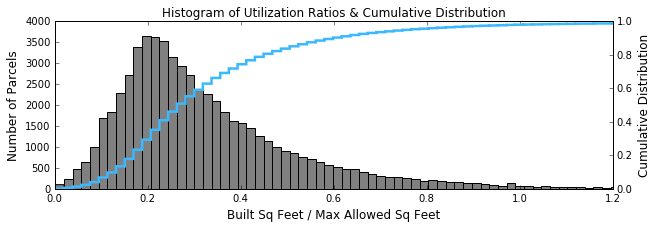

In [26]:
fig, ax1 = pl.subplots()
fig.set_figheight(3)
fig.set_figwidth(10)

nbins = 80

ax1.hist(simp.utilized[simp.utilized < 1.5].values, nbins, color='grey')
ax1.set_title('Histogram of Utilization Ratios & Cumulative Distribution')
ax1.set_xlabel('Built Sq Feet / Max Allowed Sq Feet', fontsize = 12)
ax1.set_ylabel('Number of Parcels', fontsize = 12)
ax1.set_xlim(0,1.2)
# plt.show()

ax2 = ax1.twinx()

ax2.hist(simp.utilized[simp.utilized < 1.5].values, nbins, color='#3BB9FF', normed=1, cumulative=True, 
         histtype='step', lw=2.5)
ax2.set_ylabel('Cumulative Distribution', fontsize = 12)
ax2.set_ylim(0,1)
ax2.set_xlim(0,1.2)
# plt.show()

####Linear Regression -- OLS

In [27]:
set1 = pd.concat([simp.valsqft, simp.utilized], axis=1)
set1.rename(columns={'valsqft':'x', 'utilized':'y'}, inplace=True)
set1 = set1.sort('x')

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [28]:
print 'Land Value 1st Degree Polynomial'
ols1_value = sm.ols(formula='y ~ x + I((x))', data=set1, missing='drop').fit()
print (ols1_value.summary())

print '\n \nLand Value 2nd Degree Polynomial'
ols2_value = sm.ols(formula='y ~ x + I((x)) + I ((x)**2)', data=set1, missing='drop').fit()
print (ols2_value.summary())

print '\n \nLand Value 3rd Degree Polynomial'
ols3_value = sm.ols(formula='y ~ x + I((x)) + I ((x)**2) + I ((x)**3)', data=set1, missing='drop').fit()
print (ols3_value.summary())

Land Value 1st Degree Polynomial
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     8638.
Date:                Mon, 14 Dec 2015   Prob (F-statistic):               0.00
Time:                        11:00:27   Log-Likelihood:                -45892.
No. Observations:               63495   AIC:                         9.179e+04
Df Residuals:                   63492   BIC:                         9.182e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.26

####Plotting data with best fit lines

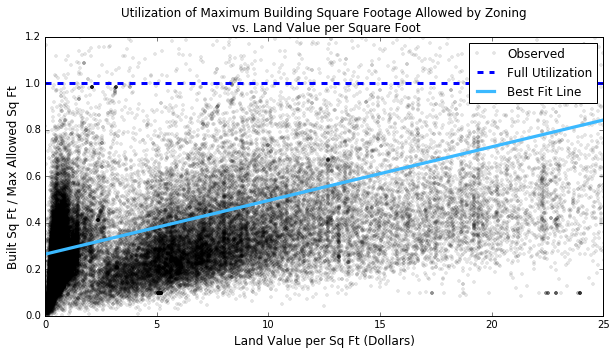

In [29]:
pl.figure(figsize=(10,5))

pl.plot(simp.valsqft, simp.utilized, 
        '.', alpha=.1, label='Observed', color='black')

pl.plot((0, 100), (1, 1), 'b--', lw=3, label='Full Utilization')
pl.plot(set1.x, ols1_value.predict(), label='Best Fit Line', lw=3.2, color='#3BB9FF')
# pl.plot(set1.x, ols2_value.predict(), label='2d Fit Line', lw=3.2, color='r')
# pl.plot(set1.x, ols3_value.predict(), label='3d Fit Line', lw=3.2, color='g')

pl.xlim(0,25)
pl.xlabel('Land Value per Sq Ft (Dollars)', fontsize = 12)
pl.ylim(0,1.2)
pl.ylabel('Built Sq Ft / Max Allowed Sq Ft', fontsize = 12)
pl.title('Utilization of Maximum Building Square Footage Allowed by Zoning\n vs. Land Value per Square Foot')
pl.legend(fontsize = 12)

In [30]:
median(simp.utilized)

0.28438840071144855

#####Log-likelihood ratio to test linear regression models

In [31]:
lr =  -2*(ols1_value.llf-ols2_value.llf )
print ("1 --> 2 lr = ", lr)

lr =  -2*(ols2_value.llf-ols3_value.llf )
print ("2 --> 3 lr = ", lr)

('1 --> 2 lr = ', 1786.7364897773223)
('2 --> 3 lr = ', 99.241817771748174)


#####All ratios are greater than the critical value of 3.84 (for alpha of 0.05)

---
##4. Examining Data by Year Built

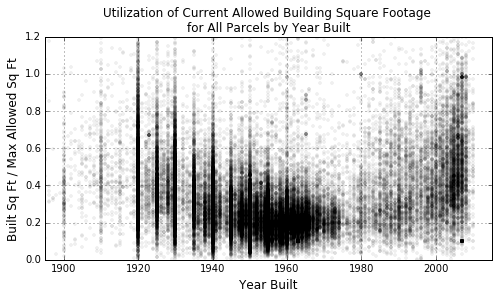

In [32]:
pl.figure(figsize=(8,4))

pl.plot(simp.YrBuilt[simp.YrBuilt>0], simp.utilized[simp.YrBuilt>0], '.', color='black', alpha=0.06)
pl.ylim(0,1.2)
pl.xlim(1895,2015)
pl.title('Utilization of Current Allowed Building Square Footage \nfor All Parcels by Year Built')
pl.ylabel('Built Sq Ft / Max Allowed Sq Ft', fontsize=12)
pl.xlabel('Year Built', fontsize=12)
pl.grid()

(1890, 2014)

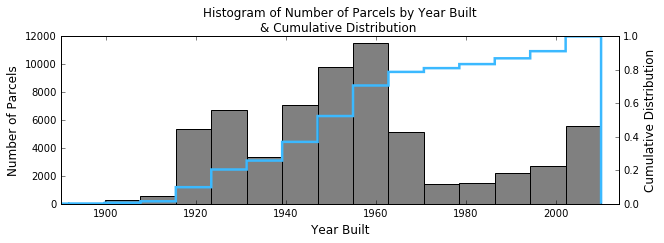

In [33]:
fig, ax1 = pl.subplots()
fig.set_figheight(3)
fig.set_figwidth(10)

nbins = 24

ax1.hist(simp.YrBuilt[simp.YrBuilt > 0].values, nbins, color='grey')
ax1.set_title('Histogram of Number of Parcels by Year Built\n& Cumulative Distribution ')
ax1.set_xlabel('Year Built', fontsize = 12)
ax1.set_ylabel('Number of Parcels', fontsize = 12)
ax1.set_xlim(1890,2014)

ax2 = ax1.twinx()

ax2.hist(simp.YrBuilt[simp.YrBuilt > 0].values, nbins, color='#3BB9FF', normed=1, cumulative=True, 
         histtype='step', lw=2.5)
ax2.set_ylabel('Cumulative Distribution', fontsize = 12)
ax2.set_ylim(0,1)
ax2.set_xlim(1890,2014)

In [34]:
median(simp.YrBuilt[simp.YrBuilt > 0])

1953.0